In [ ]:
import os 

ZIP_LOCATION = "/content/drive/MyDrive/Academics/Courses/Deep Learning/CA3/Q2/"
!unzip -qo "$ZIP_LOCATION/SemEval2010_task8_all_data.zip"

os.environ["KAGGLE_CONFIG_DIR"] = "/content/drive/MyDrive/kaggle"

!kaggle datasets download -d yutanakamura/glove42b300dtxt
!unzip -qo "/content/glove42b300dtxt.zip"

 99% 1.77G/1.80G [00:31<00:00, 35.3MB/s]
100% 1.80G/1.80G [00:31<00:00, 62.0MB/s]


In [ ]:
import os
import gc
from pathlib import Path
import itertools
import collections

import json

import string
import re


import numpy as np
import pandas as pd


import seaborn as sn
import matplotlib.pyplot as plt
import matplotlib as mpl

from tqdm.auto import tqdm

from sklearn.metrics import (accuracy_score,
                             f1_score, precision_score, 
                             recall_score, confusion_matrix, 
                             classification_report)


import torch
from torch.nn import functional as F
import torchtext
from torch import nn
from torch.utils.data import Dataset, DataLoader, random_split


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


## Matplotlib
plt.rc('font', family='serif')
plt.rcParams['font.size'] = 14
plt.rcParams['axes.linewidth'] = 2

plt.rc('font', family='serif')
plt.rc('xtick', labelsize='x-small')
plt.rc('ytick', labelsize='x-small')
plt.rcParams['legend.title_fontsize'] = 'xx-small'

# Pre-start definitions

### Constants

In [ ]:
SAVE_LOCATION = "/content/drive/MyDrive/Academics/Courses/Deep Learning/CA3/Q2/results"
Path.mkdir(Path(SAVE_LOCATION), parents=True, exist_ok=True)

LABELS_MAP = {
  label.strip(): idx for idx, label in enumerate(
       '''Cause-Effect
          Instrument-Agency
          Product-Producer
          Content-Container
          Entity-Origin
          Entity-Destination
          Component-Whole
          Member-Collection
          Message-Topic
          Other'''.splitlines())
}

FROM_TO_MAP = {
    "e1 e2": [1, 0],
    "e2 e1": [0, 1],
    np.nan: [0, 0],
}

# VOCABULARY
MIN_WORD_FREQ = 3
MIN_WORD_LENGTH  = 2
UNK_TOKEN = "<UNK>"
END_TOKEN = "<END>"
PAD_TOKEN = "<PAD>"
START_TOKEN = "<START>"
PUNCT_TOKEN = "<PUNCT>"

# TRAIN PARAMS
MAX_EPOCHS = 200
TRAIN_BATCH_SIZE = 256
TEST_BATCH_SIZE = 512
LEARNING_RATE = 10e-5 # Learning Rate
WEIGHT_DECAY = 10e-2 # Weight Decay
EARLY_STOPPING_PATIENCE = 10
EARLY_STOPPING_START_EPOCH = 60

### Utilities

In [ ]:
# https://stackoverflow.com/a/35572247

def plot_confusion_matrix(conf_mat, labels):
  if isinstance(conf_mat, np.ndarray):
    cont_mat = list(conf_mat)
  df_cm = pd.DataFrame(conf_mat,
                       index = labels,
                       columns = labels)
  fig = plt.figure(figsize=(10,7))
  sn.heatmap(df_cm, annot=True, cmap="Blues",  annot_kws={"size": 9})
  plt.yticks(rotation=0) 
  plt.xticks(rotation=45)
  plt.text(
      0.01, 0.6, 
      "True Labels", 
      fontdict=dict(fontsize=14), 
      rotation=90, ha="center", va="center",
      transform=fig.transFigure
  )
  plt.text(
      0.5, 0.01, "Predicted Labels", 
      fontdict=dict(fontsize=14), rotation=0,
      ha="center", va="center",
      transform=fig.transFigure
  )
  plt.tight_layout(rect=(0.05,0.05,0.95, 0.95))

# Dataset Steps

### Reading the dataset

In [ ]:
#########################
#########################

def read_file(file_loc):
  data = []
  RELATION_RE = re.compile(r"[\(,\)]")
  SENT_RE = re.compile(r"[\"]")
  with open(file_loc) as rfile:
    item = {}
    for idx, line in enumerate(rfile):
      line = line.strip()
      if idx % 4 == 0:
        item["sent"] = SENT_RE.sub("", line.split("\t")[-1])
      if idx % 4 == 1:
        line = RELATION_RE.sub(" ", line).split()
        item["relation"] = line[0]
        if len(line) > 1:
          item["from-to"] = " ".join([line[1], line[2]])
      # skip comment
      if idx % 4 == 3:
        data.append(item)
        item = {}
  return data

# #########################
# #########################
# def read_test_file(train_file_loc):
#   data = []
#   with open(train_file_loc) as rfile:
#     item = {}
#     for idx, line in enumerate(rfile):
#       item["sent"] = line
#       data.append(item)
#   return data
train_data = read_file("/content/SemEval2010_task8_all_data/SemEval2010_task8_training/TRAIN_FILE.TXT")
test_data = read_file("/content/SemEval2010_task8_all_data/SemEval2010_task8_testing_keys/TEST_FILE_FULL.TXT")

train_df = pd.DataFrame(train_data)
train_df = train_df.iloc[:7110]
test_df = pd.DataFrame(test_data)

### Preprocessing

In [ ]:
class RowPreProcessor:
  ENTITY_RELATION = re.compile(r"(?<=<(e1|e2)>)(.*?)(?=<\/(e1|e2)>)")
  ENITTY_NOT_RELATION = re.compile(r"(<(e1|e2)>)(.*?)(<\/(e1|e2)>)")
  DUMMY_TOKEN = "##!!#@#@!"
  PUNCT = "!"#$%&'()*+,./:;<=>?@[\]^_`{|}~"
  def __call__(self, row):
      row = self._find_entities(row)
      row = self._clean_text(row)
      row = self._entities2idx(row)
      return row

  def _find_entities(self, row):
    text = row["sent"]
    found = RowPreProcessor.ENTITY_RELATION.findall(text)
    unmatched = RowPreProcessor.ENITTY_NOT_RELATION.sub(RowPreProcessor.DUMMY_TOKEN,
                                                        text)
    unmatched = unmatched.split(RowPreProcessor.DUMMY_TOKEN)
    ents = []
    for (e, val, _) in found:
      val = val.lower()
      row[e] = val
      ents.append(val)
    # create the altered text
    text = f"{unmatched[0]} {ents[0]} {unmatched[1]} {ents[1]} {unmatched[2]}"  
    row["cleaned"] = text
    return row

  # Fast tokenization
  def _clean_text(self, row):
    text = row["cleaned"]
    text = text.translate(str.maketrans("","",RowPreProcessor.PUNCT)) # Removing punctuation
    text = text.lower() # Lowercase
    text = [t if len(t) >= MIN_WORD_LENGTH else UNK_TOKEN for t in text.split()]
    row["cleaned"] = text
    return row

  def _entities2idx(self, row):
    text = row["cleaned"]
    row["e1_index"] = text.index(row["e1"].split()[0])
    row["e2_index"] = text.index(row["e2"].split()[0])
    return row
  

processor = RowPreProcessor()
print("train samples...")
train_df = train_df.apply(processor, axis=1)
print("test samples...")
test_df = test_df.apply(processor, axis=1)

train samples...
test samples...


### Creating Vocabulary

In [ ]:
class Vocabulary:
  def __init__(self, tokenized_sents):
    counter = collections.Counter(itertools.chain(*tokenized_sents))
    words = []
    for w, c in counter.items():
      if c >= MIN_WORD_FREQ:
        words.append(w)
    words = [PAD_TOKEN, UNK_TOKEN, START_TOKEN, END_TOKEN] + words
    words = sorted(set(words))
    self.dictionary = {w: idx for idx, w in enumerate(words)}
    self.id2word = {idx: w for idx, w in enumerate(words)}
  
  def __len__(self):
    return len(self.dictionary)


dataset_vocab = Vocabulary(train_df["cleaned"])
print(len(dataset_vocab))

5556


### Creating the Dataset Class

In [ ]:
class SemEvalDataset(Dataset):
  def __init__(self,
               dataframe,
               vocab):
    self.df = dataframe
    self.vocab = vocab
    self.train = True
  
  def __len__(self):
    return len(self.df)

  def __getitem__(self, idx):
    # get the ith row of dataframe
    row = self.df.iloc[idx]
    if self.train:
      # Adding paddings to the text
      text = [START_TOKEN] + row["cleaned"] + [END_TOKEN]
      token_ids = [self.vocab.dictionary.get(t, 
                                            self.vocab.dictionary[UNK_TOKEN]) for t in text]

      label = LABELS_MAP[row["relation"]] 
      

      # Finding indices of two entities tokens
      e1_idx = row["e1_index"]
      e1_length = row["e1"].split().__len__()
      e2_idx = row["e2_index"]
      e2_length = row["e2"].split().__len__()

      # a list of indices for each entity pair
      e1_indices = list(range(e1_idx, e1_idx+e1_length))
      e2_indices = list(range(e2_idx, e2_idx+e2_length))

      data = {
              "token_ids": token_ids,
              "text_length": len(token_ids),
              "label": label,
              "mask_indices": (e1_indices, e2_indices)
      }
    else:
      # not wanting to have outputs
      data = row
    return data

In [ ]:
train_df

,sent,relation,from-to,e1,e2,cleaned,e1_index,e2_index
0,The system as described above has its greatest...,Component-Whole,e2 e1,configuration,elements,"[the, system, as, described, above, has, its, ...",12,15
1,The <e1>child</e1> was carefully wrapped and b...,Other,NaN,child,cradle,"[the, child, was, carefully, wrapped, and, bou...",1,9
2,The <e1>author</e1> of a keygen uses a <e2>dis...,Instrument-Agency,e2 e1,author,disassembler,"[the, author, of, <UNK>, keygen, uses, <UNK>, ...",1,7
3,A misty <e1>ridge</e1> uprises from the <e2>su...,Other,NaN,ridge,surge,"[<UNK>, misty, ridge, uprises, from, the, surg...",2,6
4,The <e1>student</e1> <e2>association</e2> is t...,Member-Collection,e1 e2,student,association,"[the, student, association, is, the, voice, of...",1,2
...,...,...,...,...,...,...,...,...
7105,The <e1>map</e1> was locked in a <e2>safe</e2>...,Content-Container,e1 e2,map,safe,"[the, map, was, locked, in, <UNK>, safe, in, h...",1,6
7106,It was probable that the Mn <e1>atom</e1> went...,Entity-Origin,e1 e2,atom,site,"[it, was, probable, that, the, mn, atom, went,...",6,12
7107,Agriculture has again become a <e1>producer</e...,Cause-Effect,e1 e2,producer,energy,"[agriculture, has, again, become, <UNK>, produ...",5,9
7108,Tiger Woods' <e1>mother-in-law</e1> was releas...,Entity-Origin,e1 e2,mother-in-law,hospital,"[tiger, woods', mother-in-law, was, released, ...",2,7


### Some logics needed in getting the data in minibatches

In [ ]:
class BatchProcessor:
  def __init__(self, padding_idx):
    self.padding_idx = padding_idx

  def __call__(self, data):
    # All to lists
    final_item = {k: [] for k in data[0].keys()}
    for d in data:
      for k in final_item.keys():
        final_item[k].append(d[k])
    
    for k in ["label", "text_length"]:
      final_item[k] = torch.LongTensor(final_item[k]).detach()
      
    # Pad sequence
    final_item["token_ids"] = [torch.LongTensor(t) for t in final_item["token_ids"]]
    final_item["token_ids"] = nn.utils.rnn.pad_sequence(
        final_item["token_ids"],
        batch_first=True,
        padding_value=self.padding_idx
    )
    return final_item

### Creating Dataset and DataLoader instances

In [ ]:
dataset = SemEvalDataset(train_df, dataset_vocab)

train_length = int(0.9 * len(dataset))
val_length = len(dataset) - train_length

train_dataset, val_dataset = random_split(dataset, 
                                          [train_length, val_length], 
                                          torch.Generator(device="cpu").manual_seed(42))

test_dataset = SemEvalDataset(test_df, dataset_vocab)

In [ ]:
batch_processor = BatchProcessor(
  dataset_vocab.dictionary[PAD_TOKEN]
)

train_loader_params = {
    "batch_size": TRAIN_BATCH_SIZE,
    "num_workers": 2,
    "prefetch_factor": 2,
    "collate_fn": batch_processor
}

test_val_loader_params = {
    "batch_size": TEST_BATCH_SIZE,
    "collate_fn": batch_processor
}

train_loader = DataLoader(train_dataset, **train_loader_params)
val_loader = DataLoader(val_dataset, **test_val_loader_params)
test_loader = DataLoader(test_dataset, **test_val_loader_params)

# Defining LSTM

### Simple LSTM for Parts A and B

In [ ]:
class SimpleLSTMNet(nn.Module):
  def __init__(self, 
               vocab_size,
               padding_idx, 
               preload_weights=None,
               ):
    super().__init__()
    if preload_weights is None:
      self.embed = nn.Embedding(vocab_size, 100, padding_idx=padding_idx)
    else:
      self.embed = nn.Embedding.from_pretrained(preload_weights)
      for param in self.embed.parameters():
        param.requires_grad = False

    
    self.lstm = nn.LSTM(
        input_size = self.embed.embedding_dim,
        hidden_size=150,
        num_layers=2,
        batch_first=True,
        bidirectional=True,
        dropout=0.5
    )
    self.drop = nn.Dropout(p=0.5)
    self.fc = nn.Linear(
        self.lstm.hidden_size * 2,
        len(LABELS_MAP),
    )

    self.modules = nn.ModuleList([self.embed, self.lstm, self.drop, self.fc])
  
  def forward(self, X, lengths, hidden=None):
    # getting desired info
    batch_size, seq_len = X.size()
    hidden_size = self.lstm.hidden_size

    X = self.embed(X)
    
    X = nn.utils.rnn.pack_padded_sequence(X, lengths, batch_first=True, enforce_sorted=False)
    # unsorted_indices = X.unsorted_indices
    
    _, (hn, _) = self.lstm(X, hidden)
        
    
    # switching to small x, means the last layers hidden state
    # num_layers * num_directions, batch, hidden_size
    x = hn.view(2, 2, batch_size, hidden_size)[-1] #selecting the last layer's hidden state
    x = torch.cat((x[0], x[1]), dim=-1)
    

    # it should be resized to this
    # shape: (batch_size, self.lstm.hidden_size * 2)
    x = x.contiguous()
    x = self.drop(x)
    x = self.fc(x)
    log_probs = F.log_softmax(x, dim=1)

    return log_probs

### Sophisticated LSTM for Part C

In [ ]:
class ChannelPool(nn.Module):
    def forward(self, input):
        input_max, input_indexes = torch.max(input, dim=-1)
        return input_max, input_indexes
  
class ChannelAverage(nn.Module):
    def forward(self, input):
        output = torch.mean(input, dim=-1)
        return output

  
class SophisticatedLSTMNet(nn.Module):
  
  def __init__(self, 
               vocab_size,
               padding_idx, 
               preload_weights=None,
               ):
    super().__init__()
    if preload_weights is None:
      self.embed = nn.Embedding(vocab_size, 100, padding_idx=padding_idx)
    else:
      self.embed = nn.Embedding.from_pretrained(preload_weights)
      for param in self.embed.parameters():
        param.requires_grad = False

    
    self.lstm = nn.LSTM(
        input_size = self.embed.embedding_dim,
        hidden_size=150,
        num_layers=2,
        batch_first=True,
        bidirectional=True,
        dropout=0.5
    )

    self.drop = nn.Dropout(p=0.5)

    self.fc = nn.Linear(
        self.lstm.hidden_size * 2,
        len(LABELS_MAP),
    )

    self.modules = nn.ModuleList([self.embed,
                                  self.lstm,
                                  self.drop,
                                  self.fc])
    
  def forward(self, X, lengths, mask_indices, hidden=None):
    # getting desired info
    batch_size, seq_len = X.size()
    hidden_size = self.lstm.hidden_size

    X = self.embed(X)
    
    X = nn.utils.rnn.pack_padded_sequence(X, lengths, batch_first=True, enforce_sorted=False)
    # unsorted_indices = X.unsorted_indices
    
    X, _ = self.lstm(X, hidden)

    # revert back
    X, reverted_lengths =  torch.nn.utils.rnn.pad_packed_sequence(X, batch_first=True)
    

    # True shape: (seq_len, batch, num_directions * hidden_size)
    X = X.view(batch_size, seq_len, hidden_size, 2)
    # changing outputs shape to a new shape:
    #   (batch_size, hidden_size, sequence_length, num_directions)
    X = X.permute(0, 2, 1, 3) 
    X = X.contiguous()

    X, _ = X.max(dim=-1)
    
    x = []
    for sample_idx, indices in enumerate(mask_indices):
      e1_indices, e2_indices = indices
      e1 = X[sample_idx, ..., e1_indices].mean(-1)
      e2 = X[sample_idx, ..., e2_indices].mean(-1)
      e_cat = torch.cat((e1, e2))
      x.append(e_cat)
    
    # adding batches togehter
    x = torch.stack(x, dim=0)

    # it should be resized to this
    # shape: (batch_size, self.lstm.hidden_size * 2)
    x = x.contiguous() 
    x = self.drop(x)
    x = self.fc(x)
    log_probs = F.log_softmax(x, dim=1)

    return log_probs

#### Trainer and Evaluation functions for Network

In [ ]:
# From here: https://debuggercafe.com/using-learning-rate-scheduler-and-early-stopping-with-pytorch/
class EarlyStopping():
    """
    Early stopping to stop the training when the loss does not improve after
    certain epochs.
    """
    def __init__(self, save_label, patience=5, min_delta=0, start_epoch=20):
        """
        :param patience: how many epochs to wait before stopping when loss is
               not improving
        :param min_delta: minimum difference between new loss and old loss for
               new loss to be considered as an improvement
        """
        self.save_label = save_label
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = None
        self.early_stop = False
        self.start_epoch = start_epoch
        
    def __call__(self, val_loss, epoch, model):

      if self.best_loss is None or self.best_loss - val_loss > self.min_delta:
          self.best_loss = val_loss
          self._save_best_model(model)

      elif epoch >= self.start_epoch and self.best_loss - val_loss < self.min_delta:
          self.counter += 1
          print(f"INFO: Early stopping counter {self.counter} of {self.patience}")
          if self.counter >= self.patience:
              print('INFO: Early stopping')
              self.early_stop = True
    
    def _save_best_model(self, model):
      torch.save(
          model.state_dict(), os.path.join(SAVE_LOCATION, f"{self.save_label}.model")
      )
    
    def load_best_model(self, model):
      model.load_state_dict(torch.load(os.path.join(SAVE_LOCATION, f"{self.save_label}.model")))
      return model

In [ ]:
def eval_function(model, loader, eval_type, compute_fpr = False):
  
  gpu = device.type == "cuda"
  # model should be in eval mode
  model.eval()
  
  num_samples = 0
  running_loss = 0
  running_acc = 0
  eval_info = {}
  if compute_fpr:
    total_targets = []
    total_outputs = []
  
  with torch.no_grad():
    for batch in loader:
      token_ids = batch["token_ids"].to(device)
      lengths = batch["text_length"]
      mask_indices = batch["mask_indices"]
      targets = batch["label"].to(device)

      forward_inputs = dict(X=token_ids, lengths=lengths)
      if isinstance(model, SophisticatedLSTMNet):
        forward_inputs["mask_indices"] = mask_indices
      
      probs = model(**forward_inputs)

      loss = loss_fn(probs, targets)

      batch_size = targets.numel()
      batch_loss = loss.item()

      num_samples += batch_size
      running_loss += batch_loss * batch_size

      outputs = probs.argmax(1).detach().cpu().numpy()
      targets = targets.detach().cpu().numpy()
        
      running_acc += accuracy_score(targets, outputs) * batch_size

      # Precision, recall, f1
      if compute_fpr:
        total_targets.extend(list(targets))
        total_outputs.extend(list(outputs))

  eval_loss = running_loss / num_samples
  eval_acc = running_acc / num_samples


  eval_info = {
      f"{eval_type}_loss": eval_loss,
      f"{eval_type}_acc": eval_acc
  }

  if compute_fpr:
    eval_info[f"{eval_type}_classification_report"] = classification_report(total_targets,
                                                                            total_outputs,
                                                                            labels=list(LABELS_MAP.values()),
                                                                            target_names=list(LABELS_MAP.keys()),
                                                                            output_dict=True)
                                                          
    eval_info[f"{eval_type}_conf_mat"] = confusion_matrix(total_targets, 
                                                          total_outputs, 
                                                          labels=list(LABELS_MAP.values()))
                                                          # normalize='pred')

  return eval_info


def train_function(
    model,
    opt,
    loss_fn,
    train_loader,
    val_loader,
    experiment_name,
    max_epochs=MAX_EPOCHS,
    early_stopping_patience=EARLY_STOPPING_PATIENCE,
    early_stopping_start_epoch=EARLY_STOPPING_START_EPOCH,
):
  gpu = device.type == "cuda"
  if gpu:
    scaler = torch.cuda.amp.GradScaler()
  info = []
  early_stopper = EarlyStopping(
      save_label = experiment_name,
      patience=early_stopping_patience,
      min_delta=0,
      start_epoch=EARLY_STOPPING_START_EPOCH
  )
  for epoch in range(1, max_epochs+1):
    model.train()
    running_loss = 0.0
    running_acc = 0.0
    n_items = 0
    pbar = tqdm(total=len(train_loader), leave=False)
    for batch in train_loader:
      opt.zero_grad() # make sure the gradient is zero everytime we start

      token_ids = batch["token_ids"].to(device)
      lengths = batch["text_length"]
      mask_indices = batch["mask_indices"]
      targets = batch["label"].to(device)

      forward_inputs = dict(X=token_ids, lengths=lengths)

      if isinstance(model, SophisticatedLSTMNet):
        forward_inputs["mask_indices"] = mask_indices

      if gpu:
        with torch.cuda.amp.autocast():
          probs = model(**forward_inputs)
          loss = loss_fn(probs, targets)
          
        scaler.scale(loss).backward()
        scaler.step(opt)
        scaler.update()

      else:
        probs = model(**forward_inputs)
        loss = loss_fn(probs, targets)
        loss.backward()
        opt.step()
      
      # updating total number of samples
      batch_size = targets.numel()
      n_items += batch_size

      # computing the running loss
      batch_loss = loss.item()
      running_loss +=  batch_loss * batch_size
      
      # computing accuracies
      outputs = probs.argmax(1).detach().cpu().numpy()
      targets = targets.detach().cpu().numpy()

      batch_acc = accuracy_score(targets, outputs)
      running_acc += batch_acc * batch_size

      # updating the progress bar
      pbar.set_postfix(batch_loss=f"{batch_loss:.3f}")
      pbar.update()

    # Finished this epoch's training
    pbar.close()
    epoch_info = {
        "train_loss": running_loss / n_items,
        "train_acc": running_acc / n_items,   
    }

    val_info = eval_function(model, val_loader, "val")

    epoch_info.update(val_info)

    print(
        f"EPOCH: {epoch}\t" + "\t".join([" ".join([k, f'{v:.3f}']) for k, v in epoch_info.items()])
    )
    epoch_info["epoch"] = epoch
    info.append(epoch_info)

    # flushing everything after this epoch
    gc.collect()
    torch.cuda.empty_cache()

    with open(os.path.join(SAVE_LOCATION, f"{experiment_name}.json"), "w") as jfile:
      json.dump(info, jfile)

    early_stopper(epoch_info["val_loss"], epoch, model)
    if early_stopper.early_stop:
      model = early_stopper.load_best_model(model)
      break
  
  return info, model


# TQDM color fix

In [ ]:
# Set the tqdm text color to white.

from IPython.display import HTML, display

def set_css_in_cell_output():
    display(HTML('''
        <style>
            .jupyter-widgets {color: #d5d5d5 !important;}
            .widget-label {color: #d5d5d5 !important;}
        </style>
    '''))

get_ipython().events.register('pre_run_cell', set_css_in_cell_output)

In [ ]:
def visualize_info(label, train_info, test_info):
  import matplotlib.ticker as mtick
  # creating training info
  capitalized_label = " ".join([l.capitalize() for l in label.split("_")])
  train_df = pd.DataFrame(train_info[label])
  fig, axes = plt.subplots(2, 1, figsize=(9,12))
  [ax.grid("on") for ax in axes]
  ax = axes[0]
  ax.plot(train_df["epoch"], train_df["train_loss"], color= "royalblue", label="Train")
  ax.plot(train_df["epoch"], train_df["val_loss"], color="crimson", label="Validation")
  ax.set_ylabel("Loss")
  ax.set_ylim(ymin=0)
  ax = axes[1]
  ax.plot(train_df["epoch"], train_df["train_acc"], color = "royalblue", label="Train")
  ax.plot(train_df["epoch"], train_df["val_acc"], color="crimson", label="Validation")
  ax.yaxis.set_major_formatter(mtick.PercentFormatter(1.0))
  ax.set_ylabel("Accuracy", fontsize=14)
  ax.set_xlabel("Epochs", fontsize=14)
  ax.set_ylim(0, 1)
  handles, labels = ax.get_legend_handles_labels()
  fig.legend(handles, 
             labels, 
             loc=(0.3,0.94),
             handlelength = 3.5,
             handletextpad = 1.5,
             borderpad=0.3,
             prop={'size':11},
             ncol=2, )
  plt.tight_layout(rect=(0.1,0.05,0.9, 0.94))
  fig.suptitle(f"Loss and Accuracy of {capitalized_label} Model During Training", fontsize=18)


  # creating testing info
  plot_confusion_matrix(test_info[label]["test_conf_mat"], LABELS_MAP.keys())
  plt.title(f"Confusion Matrix of {capitalized_label} Model")
  

  # plotting the table
  fig, ax = plt.subplots(figsize=(16,11), constrained_layout=True)
  ax.set_position([0, 0, 1, 1])
  ax.axis('off')
  df = pd.DataFrame(test_info[label]["test_classification_report"]).transpose()
  df.columns = [t.capitalize() for t in df.columns]
  df.index = [t.capitalize() for t in df.index]
  df = np.round(df, 2)
  df = df.infer_objects()
  acc = float(df.loc[["Accuracy"]]["Precision"])
  df.drop("Accuracy", axis=0, inplace=True)
  table = pd.plotting.table(
    data=df,
    loc = "center",
    cellLoc='center',
    ax=ax    
  )
  table.set_fontsize(34)
  table.scale(1, 4)
  from matplotlib.font_manager import FontProperties

  for (row, col), cell in table.get_celld().items():
    if row in range(11, 14): #and (col != ):
      cell.set_text_props(fontproperties=FontProperties(weight='bold', size=34))
    else:
      cell.set_text_props(fontproperties=FontProperties(size=34))
  

  mid = (fig.subplotpars.right + fig.subplotpars.left)/2
  fig.text(
      x = 0.4,
      y = 0.95,
      s = f"Metrics of {capitalized_label} Model on Test Dataset",
      fontsize=48,
      horizontalalignment="center",
      transform=fig.transFigure
    )
  fig.text(
      x = 0.4,
      y = 0.05,
      s = f"Accuracy on Test Set: {acc:.2f}",
      fontsize = 34,
      horizontalalignment="center",
      transform=fig.transFigure)
  
  

# Train Part A

In [ ]:
train_info = {}
test_info = {}

In [ ]:
model = SimpleLSTMNet(
    len(dataset_vocab),
    dataset_vocab.dictionary[PAD_TOKEN],
    preload_weights=None
).to(device)

opt = torch.optim.AdamW(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)

loss_fn = nn.NLLLoss().to(device)

In [ ]:
label = "part_a"
# Training
train_info[label], model = train_function(model, 
             opt, 
             loss_fn, 
             train_loader, 
             val_loader,
             experiment_name=label,
             max_epochs=MAX_EPOCHS)

# Testing
test_info[label] = eval_function(model, test_loader, "test", True)

EPOCH: 1	train_loss 2.293	train_acc 0.127	val_loss 2.281	val_acc 0.142


EPOCH: 2	train_loss 2.267	train_acc 0.159	val_loss 2.267	val_acc 0.143


EPOCH: 3	train_loss 2.255	train_acc 0.161	val_loss 2.262	val_acc 0.143


EPOCH: 4	train_loss 2.241	train_acc 0.162	val_loss 2.250	val_acc 0.143


EPOCH: 5	train_loss 2.214	train_acc 0.180	val_loss 2.211	val_acc 0.181


EPOCH: 6	train_loss 2.134	train_acc 0.246	val_loss 2.101	val_acc 0.256


EPOCH: 7	train_loss 2.023	train_acc 0.286	val_loss 2.009	val_acc 0.278


EPOCH: 8	train_loss 1.936	train_acc 0.310	val_loss 1.941	val_acc 0.278


EPOCH: 9	train_loss 1.869	train_acc 0.333	val_loss 1.876	val_acc 0.308


EPOCH: 10	train_loss 1.799	train_acc 0.360	val_loss 1.821	val_acc 0.335


EPOCH: 11	train_loss 1.740	train_acc 0.394	val_loss 1.771	val_acc 0.367


EPOCH: 12	train_loss 1.695	train_acc 0.413	val_loss 1.721	val_acc 0.395


EPOCH: 13	train_loss 1.646	train_acc 0.425	val_loss 1.701	val_acc 0.402


EPOCH: 14	train_loss 1.608	train_acc 0.435	val_loss 1.672	val_acc 0.426


EPOCH: 15	train_loss 1.578	train_acc 0.442	val_loss 1.662	val_acc 0.432


EPOCH: 16	train_loss 1.548	train_acc 0.457	val_loss 1.639	val_acc 0.454


EPOCH: 17	train_loss 1.524	train_acc 0.460	val_loss 1.625	val_acc 0.449


EPOCH: 18	train_loss 1.497	train_acc 0.469	val_loss 1.612	val_acc 0.461


EPOCH: 19	train_loss 1.467	train_acc 0.481	val_loss 1.613	val_acc 0.463


EPOCH: 20	train_loss 1.437	train_acc 0.495	val_loss 1.602	val_acc 0.464


EPOCH: 21	train_loss 1.415	train_acc 0.501	val_loss 1.594	val_acc 0.464


EPOCH: 22	train_loss 1.398	train_acc 0.505	val_loss 1.585	val_acc 0.464


EPOCH: 23	train_loss 1.363	train_acc 0.519	val_loss 1.590	val_acc 0.473


EPOCH: 24	train_loss 1.344	train_acc 0.525	val_loss 1.582	val_acc 0.481


EPOCH: 25	train_loss 1.315	train_acc 0.537	val_loss 1.580	val_acc 0.473


EPOCH: 26	train_loss 1.296	train_acc 0.543	val_loss 1.581	val_acc 0.473


EPOCH: 27	train_loss 1.265	train_acc 0.558	val_loss 1.575	val_acc 0.473


EPOCH: 28	train_loss 1.241	train_acc 0.562	val_loss 1.575	val_acc 0.475


EPOCH: 29	train_loss 1.225	train_acc 0.578	val_loss 1.575	val_acc 0.475


EPOCH: 30	train_loss 1.194	train_acc 0.578	val_loss 1.578	val_acc 0.484


EPOCH: 31	train_loss 1.193	train_acc 0.581	val_loss 1.562	val_acc 0.481


EPOCH: 32	train_loss 1.162	train_acc 0.591	val_loss 1.568	val_acc 0.494


EPOCH: 33	train_loss 1.130	train_acc 0.617	val_loss 1.566	val_acc 0.496


EPOCH: 34	train_loss 1.102	train_acc 0.614	val_loss 1.574	val_acc 0.484


EPOCH: 35	train_loss 1.089	train_acc 0.620	val_loss 1.587	val_acc 0.478


EPOCH: 36	train_loss 1.078	train_acc 0.626	val_loss 1.582	val_acc 0.491


EPOCH: 37	train_loss 1.062	train_acc 0.631	val_loss 1.578	val_acc 0.499


EPOCH: 38	train_loss 1.040	train_acc 0.639	val_loss 1.584	val_acc 0.489


EPOCH: 39	train_loss 1.015	train_acc 0.649	val_loss 1.613	val_acc 0.496


EPOCH: 40	train_loss 0.996	train_acc 0.664	val_loss 1.614	val_acc 0.492


EPOCH: 41	train_loss 0.976	train_acc 0.669	val_loss 1.630	val_acc 0.499


EPOCH: 42	train_loss 0.958	train_acc 0.677	val_loss 1.645	val_acc 0.496


EPOCH: 43	train_loss 0.943	train_acc 0.677	val_loss 1.636	val_acc 0.488


EPOCH: 44	train_loss 0.940	train_acc 0.681	val_loss 1.642	val_acc 0.502


EPOCH: 45	train_loss 0.919	train_acc 0.682	val_loss 1.620	val_acc 0.495


EPOCH: 46	train_loss 0.901	train_acc 0.688	val_loss 1.617	val_acc 0.505


EPOCH: 47	train_loss 0.892	train_acc 0.700	val_loss 1.613	val_acc 0.494


EPOCH: 48	train_loss 0.870	train_acc 0.701	val_loss 1.637	val_acc 0.499


EPOCH: 49	train_loss 0.848	train_acc 0.715	val_loss 1.663	val_acc 0.504


EPOCH: 50	train_loss 0.827	train_acc 0.722	val_loss 1.680	val_acc 0.512


EPOCH: 51	train_loss 0.803	train_acc 0.729	val_loss 1.695	val_acc 0.499


EPOCH: 52	train_loss 0.789	train_acc 0.736	val_loss 1.717	val_acc 0.504


EPOCH: 53	train_loss 0.778	train_acc 0.743	val_loss 1.706	val_acc 0.511


EPOCH: 54	train_loss 0.759	train_acc 0.747	val_loss 1.706	val_acc 0.494


EPOCH: 55	train_loss 0.744	train_acc 0.754	val_loss 1.716	val_acc 0.512


EPOCH: 56	train_loss 0.733	train_acc 0.750	val_loss 1.728	val_acc 0.511


EPOCH: 57	train_loss 0.720	train_acc 0.759	val_loss 1.735	val_acc 0.488


EPOCH: 58	train_loss 0.693	train_acc 0.767	val_loss 1.762	val_acc 0.501


EPOCH: 59	train_loss 0.671	train_acc 0.778	val_loss 1.784	val_acc 0.501


EPOCH: 60	train_loss 0.672	train_acc 0.776	val_loss 1.801	val_acc 0.485
INFO: Early stopping counter 1 of 10


EPOCH: 61	train_loss 0.665	train_acc 0.773	val_loss 1.802	val_acc 0.496
INFO: Early stopping counter 2 of 10


EPOCH: 62	train_loss 0.667	train_acc 0.778	val_loss 1.835	val_acc 0.498
INFO: Early stopping counter 3 of 10


EPOCH: 63	train_loss 0.657	train_acc 0.781	val_loss 1.818	val_acc 0.501
INFO: Early stopping counter 4 of 10


EPOCH: 64	train_loss 0.644	train_acc 0.787	val_loss 1.831	val_acc 0.481
INFO: Early stopping counter 5 of 10


EPOCH: 65	train_loss 0.668	train_acc 0.776	val_loss 1.937	val_acc 0.473
INFO: Early stopping counter 6 of 10


EPOCH: 66	train_loss 0.728	train_acc 0.753	val_loss 1.952	val_acc 0.450
INFO: Early stopping counter 7 of 10


EPOCH: 67	train_loss 0.688	train_acc 0.769	val_loss 1.837	val_acc 0.488
INFO: Early stopping counter 8 of 10


EPOCH: 68	train_loss 0.607	train_acc 0.797	val_loss 1.896	val_acc 0.474
INFO: Early stopping counter 9 of 10


EPOCH: 69	train_loss 0.584	train_acc 0.805	val_loss 1.926	val_acc 0.477
INFO: Early stopping counter 10 of 10
INFO: Early stopping


# PART B

In [ ]:
!sed -n '$=' glove.42B.300d.txt

1917494


In [ ]:
dim = 300
glove_embedding = np.random.normal(
    loc=0, scale=0.2, size=(len(dataset_vocab), dim)
).astype(np.float64)
hit = 0
print(len(dataset_vocab))
with open("glove.42B.300d.txt") as mf:
  pbar = tqdm(total=1917494, desc="glove vectors")
  for line_count, line in enumerate(mf):
    items = line.split()
    word = items[0]
    if word in dataset_vocab.dictionary:
      idx = dataset_vocab.dictionary[word]
      glove_embedding[idx, :] = np.array([float(i) for i in items[1:]], dtype=np.float64)
      hit += 1
      if hit % 20 == 0:
        pbar.set_postfix(hit=hit)
      if hit == len(dataset_vocab) - 4: #PAD START END UNK
        break
    if line_count % 1000 == 999:
      pbar.update(1000)
  pbar.close()

glove_embedding = torch.FloatTensor(glove_embedding).to(device)

5556


In [ ]:
model = SimpleLSTMNet(
    len(dataset_vocab),
    dataset_vocab.dictionary[PAD_TOKEN],
    preload_weights=glove_embedding
).to(device)

opt = torch.optim.AdamW(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)

loss_fn = nn.NLLLoss().to(device)

In [ ]:
label = "part_b"
# Training
train_info[label], model = train_function(model, 
             opt, 
             loss_fn, 
             train_loader, 
             val_loader,
             experiment_name=label,
             max_epochs=MAX_EPOCHS)

# Testing
test_info[label] = eval_function(model, test_loader, "test", True)

EPOCH: 1	train_loss 2.292	train_acc 0.128	val_loss 2.280	val_acc 0.143


EPOCH: 2	train_loss 2.265	train_acc 0.158	val_loss 2.265	val_acc 0.143


EPOCH: 3	train_loss 2.251	train_acc 0.161	val_loss 2.257	val_acc 0.143


EPOCH: 4	train_loss 2.236	train_acc 0.164	val_loss 2.230	val_acc 0.146


EPOCH: 5	train_loss 2.165	train_acc 0.225	val_loss 2.084	val_acc 0.266


EPOCH: 6	train_loss 1.918	train_acc 0.333	val_loss 1.743	val_acc 0.374


EPOCH: 7	train_loss 1.648	train_acc 0.421	val_loss 1.507	val_acc 0.475


EPOCH: 8	train_loss 1.490	train_acc 0.485	val_loss 1.414	val_acc 0.496


EPOCH: 9	train_loss 1.389	train_acc 0.521	val_loss 1.302	val_acc 0.557


EPOCH: 10	train_loss 1.312	train_acc 0.536	val_loss 1.270	val_acc 0.577


EPOCH: 11	train_loss 1.258	train_acc 0.553	val_loss 1.236	val_acc 0.589


EPOCH: 12	train_loss 1.217	train_acc 0.575	val_loss 1.213	val_acc 0.599


EPOCH: 13	train_loss 1.187	train_acc 0.583	val_loss 1.189	val_acc 0.615


EPOCH: 14	train_loss 1.150	train_acc 0.599	val_loss 1.185	val_acc 0.599


EPOCH: 15	train_loss 1.132	train_acc 0.602	val_loss 1.219	val_acc 0.592


EPOCH: 16	train_loss 1.113	train_acc 0.611	val_loss 1.148	val_acc 0.610


EPOCH: 17	train_loss 1.083	train_acc 0.619	val_loss 1.149	val_acc 0.616


EPOCH: 18	train_loss 1.061	train_acc 0.625	val_loss 1.170	val_acc 0.610


EPOCH: 19	train_loss 1.045	train_acc 0.630	val_loss 1.127	val_acc 0.624


EPOCH: 20	train_loss 1.018	train_acc 0.644	val_loss 1.145	val_acc 0.626


EPOCH: 21	train_loss 1.005	train_acc 0.643	val_loss 1.139	val_acc 0.627


EPOCH: 22	train_loss 0.981	train_acc 0.657	val_loss 1.150	val_acc 0.619


EPOCH: 23	train_loss 0.971	train_acc 0.659	val_loss 1.125	val_acc 0.630


EPOCH: 24	train_loss 0.953	train_acc 0.665	val_loss 1.139	val_acc 0.624


EPOCH: 25	train_loss 0.938	train_acc 0.671	val_loss 1.120	val_acc 0.639


EPOCH: 26	train_loss 0.907	train_acc 0.676	val_loss 1.147	val_acc 0.637


EPOCH: 27	train_loss 0.902	train_acc 0.692	val_loss 1.121	val_acc 0.643


EPOCH: 28	train_loss 0.889	train_acc 0.687	val_loss 1.137	val_acc 0.616


EPOCH: 29	train_loss 0.874	train_acc 0.695	val_loss 1.117	val_acc 0.640


EPOCH: 30	train_loss 0.872	train_acc 0.697	val_loss 1.112	val_acc 0.633


EPOCH: 31	train_loss 0.850	train_acc 0.705	val_loss 1.137	val_acc 0.623


EPOCH: 32	train_loss 0.847	train_acc 0.704	val_loss 1.141	val_acc 0.623


EPOCH: 33	train_loss 0.842	train_acc 0.704	val_loss 1.157	val_acc 0.624


EPOCH: 34	train_loss 0.818	train_acc 0.710	val_loss 1.113	val_acc 0.643


EPOCH: 35	train_loss 0.804	train_acc 0.717	val_loss 1.136	val_acc 0.636


EPOCH: 36	train_loss 0.785	train_acc 0.726	val_loss 1.132	val_acc 0.651


EPOCH: 37	train_loss 0.788	train_acc 0.727	val_loss 1.140	val_acc 0.634


EPOCH: 38	train_loss 0.768	train_acc 0.732	val_loss 1.150	val_acc 0.630


EPOCH: 39	train_loss 0.767	train_acc 0.737	val_loss 1.132	val_acc 0.644


EPOCH: 40	train_loss 0.745	train_acc 0.743	val_loss 1.137	val_acc 0.644


EPOCH: 41	train_loss 0.730	train_acc 0.749	val_loss 1.135	val_acc 0.648


EPOCH: 42	train_loss 0.721	train_acc 0.751	val_loss 1.145	val_acc 0.641


EPOCH: 43	train_loss 0.702	train_acc 0.756	val_loss 1.133	val_acc 0.655


EPOCH: 44	train_loss 0.695	train_acc 0.764	val_loss 1.139	val_acc 0.658


EPOCH: 45	train_loss 0.692	train_acc 0.761	val_loss 1.130	val_acc 0.655


EPOCH: 46	train_loss 0.679	train_acc 0.768	val_loss 1.152	val_acc 0.647


EPOCH: 47	train_loss 0.663	train_acc 0.772	val_loss 1.142	val_acc 0.658


EPOCH: 48	train_loss 0.673	train_acc 0.766	val_loss 1.154	val_acc 0.661


EPOCH: 49	train_loss 0.658	train_acc 0.770	val_loss 1.185	val_acc 0.640


EPOCH: 50	train_loss 0.656	train_acc 0.773	val_loss 1.205	val_acc 0.641


EPOCH: 51	train_loss 0.650	train_acc 0.771	val_loss 1.176	val_acc 0.648


EPOCH: 52	train_loss 0.650	train_acc 0.777	val_loss 1.149	val_acc 0.651


EPOCH: 53	train_loss 0.633	train_acc 0.780	val_loss 1.169	val_acc 0.639


EPOCH: 54	train_loss 0.633	train_acc 0.780	val_loss 1.169	val_acc 0.643


EPOCH: 55	train_loss 0.613	train_acc 0.785	val_loss 1.172	val_acc 0.644


EPOCH: 56	train_loss 0.584	train_acc 0.798	val_loss 1.198	val_acc 0.643


EPOCH: 57	train_loss 0.577	train_acc 0.808	val_loss 1.189	val_acc 0.650


EPOCH: 58	train_loss 0.559	train_acc 0.809	val_loss 1.204	val_acc 0.637


EPOCH: 59	train_loss 0.546	train_acc 0.814	val_loss 1.209	val_acc 0.643


EPOCH: 60	train_loss 0.541	train_acc 0.820	val_loss 1.218	val_acc 0.639
INFO: Early stopping counter 1 of 10


EPOCH: 61	train_loss 0.549	train_acc 0.813	val_loss 1.225	val_acc 0.650
INFO: Early stopping counter 2 of 10


EPOCH: 62	train_loss 0.536	train_acc 0.820	val_loss 1.233	val_acc 0.632
INFO: Early stopping counter 3 of 10


EPOCH: 63	train_loss 0.529	train_acc 0.819	val_loss 1.236	val_acc 0.630
INFO: Early stopping counter 4 of 10


EPOCH: 64	train_loss 0.514	train_acc 0.825	val_loss 1.272	val_acc 0.620
INFO: Early stopping counter 5 of 10


EPOCH: 65	train_loss 0.504	train_acc 0.833	val_loss 1.290	val_acc 0.619
INFO: Early stopping counter 6 of 10


EPOCH: 66	train_loss 0.489	train_acc 0.837	val_loss 1.261	val_acc 0.634
INFO: Early stopping counter 7 of 10


EPOCH: 67	train_loss 0.482	train_acc 0.839	val_loss 1.290	val_acc 0.617
INFO: Early stopping counter 8 of 10


EPOCH: 68	train_loss 0.469	train_acc 0.844	val_loss 1.291	val_acc 0.622
INFO: Early stopping counter 9 of 10


EPOCH: 69	train_loss 0.458	train_acc 0.848	val_loss 1.297	val_acc 0.643
INFO: Early stopping counter 10 of 10
INFO: Early stopping


# PART C

In [ ]:
model = SophisticatedLSTMNet(
    len(dataset_vocab),
    dataset_vocab.dictionary[PAD_TOKEN],
    preload_weights=glove_embedding
).to(device)

opt = torch.optim.AdamW(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)

loss_fn = nn.NLLLoss().to(device)

In [ ]:
label = "part_c"
# Training
train_info[label], model = train_function(model, 
             opt, 
             loss_fn, 
             train_loader, 
             val_loader,
             experiment_name=label,
             max_epochs=MAX_EPOCHS)

# Testing
test_info[label] = eval_function(model, test_loader, "test", True)

EPOCH: 1	train_loss 2.285	train_acc 0.153	val_loss 2.271	val_acc 0.143


EPOCH: 2	train_loss 2.253	train_acc 0.167	val_loss 2.243	val_acc 0.143


EPOCH: 3	train_loss 2.213	train_acc 0.175	val_loss 2.195	val_acc 0.167


EPOCH: 4	train_loss 2.131	train_acc 0.258	val_loss 2.039	val_acc 0.333


EPOCH: 5	train_loss 1.898	train_acc 0.371	val_loss 1.724	val_acc 0.387


EPOCH: 6	train_loss 1.641	train_acc 0.430	val_loss 1.482	val_acc 0.466


EPOCH: 7	train_loss 1.470	train_acc 0.491	val_loss 1.335	val_acc 0.522


EPOCH: 8	train_loss 1.343	train_acc 0.542	val_loss 1.240	val_acc 0.561


EPOCH: 9	train_loss 1.250	train_acc 0.576	val_loss 1.160	val_acc 0.594


EPOCH: 10	train_loss 1.179	train_acc 0.606	val_loss 1.101	val_acc 0.626


EPOCH: 11	train_loss 1.125	train_acc 0.619	val_loss 1.076	val_acc 0.622


EPOCH: 12	train_loss 1.080	train_acc 0.635	val_loss 1.034	val_acc 0.650


EPOCH: 13	train_loss 1.048	train_acc 0.642	val_loss 1.027	val_acc 0.648


EPOCH: 14	train_loss 1.019	train_acc 0.655	val_loss 0.998	val_acc 0.655


EPOCH: 15	train_loss 0.984	train_acc 0.663	val_loss 0.966	val_acc 0.674


EPOCH: 16	train_loss 0.952	train_acc 0.675	val_loss 0.956	val_acc 0.669


EPOCH: 17	train_loss 0.924	train_acc 0.685	val_loss 0.958	val_acc 0.665


EPOCH: 18	train_loss 0.902	train_acc 0.693	val_loss 0.949	val_acc 0.678


EPOCH: 19	train_loss 0.882	train_acc 0.701	val_loss 0.935	val_acc 0.667


EPOCH: 20	train_loss 0.867	train_acc 0.708	val_loss 0.919	val_acc 0.679


EPOCH: 21	train_loss 0.848	train_acc 0.715	val_loss 0.928	val_acc 0.675


EPOCH: 22	train_loss 0.829	train_acc 0.715	val_loss 0.912	val_acc 0.685


EPOCH: 23	train_loss 0.807	train_acc 0.727	val_loss 0.904	val_acc 0.679


EPOCH: 24	train_loss 0.791	train_acc 0.733	val_loss 0.912	val_acc 0.679


EPOCH: 25	train_loss 0.772	train_acc 0.735	val_loss 0.911	val_acc 0.688


EPOCH: 26	train_loss 0.764	train_acc 0.742	val_loss 0.904	val_acc 0.681


EPOCH: 27	train_loss 0.751	train_acc 0.749	val_loss 0.927	val_acc 0.679


EPOCH: 28	train_loss 0.736	train_acc 0.748	val_loss 0.924	val_acc 0.684


EPOCH: 29	train_loss 0.721	train_acc 0.755	val_loss 0.905	val_acc 0.679


EPOCH: 30	train_loss 0.705	train_acc 0.764	val_loss 0.907	val_acc 0.684


EPOCH: 31	train_loss 0.688	train_acc 0.767	val_loss 0.921	val_acc 0.669


EPOCH: 32	train_loss 0.679	train_acc 0.773	val_loss 0.904	val_acc 0.686


EPOCH: 33	train_loss 0.652	train_acc 0.779	val_loss 0.921	val_acc 0.671


EPOCH: 34	train_loss 0.647	train_acc 0.787	val_loss 0.931	val_acc 0.668


EPOCH: 35	train_loss 0.634	train_acc 0.792	val_loss 0.931	val_acc 0.679


EPOCH: 36	train_loss 0.625	train_acc 0.788	val_loss 0.948	val_acc 0.678


EPOCH: 37	train_loss 0.606	train_acc 0.803	val_loss 0.941	val_acc 0.681


EPOCH: 38	train_loss 0.607	train_acc 0.800	val_loss 0.961	val_acc 0.681


EPOCH: 39	train_loss 0.586	train_acc 0.805	val_loss 0.949	val_acc 0.682


EPOCH: 40	train_loss 0.582	train_acc 0.801	val_loss 0.973	val_acc 0.675


EPOCH: 41	train_loss 0.566	train_acc 0.809	val_loss 0.945	val_acc 0.686


EPOCH: 42	train_loss 0.564	train_acc 0.812	val_loss 0.939	val_acc 0.698


EPOCH: 43	train_loss 0.558	train_acc 0.812	val_loss 0.958	val_acc 0.689


EPOCH: 44	train_loss 0.551	train_acc 0.814	val_loss 0.956	val_acc 0.693


EPOCH: 45	train_loss 0.532	train_acc 0.827	val_loss 0.955	val_acc 0.696


EPOCH: 46	train_loss 0.519	train_acc 0.830	val_loss 0.963	val_acc 0.691


EPOCH: 47	train_loss 0.516	train_acc 0.828	val_loss 0.971	val_acc 0.699


EPOCH: 48	train_loss 0.503	train_acc 0.832	val_loss 0.958	val_acc 0.695


EPOCH: 49	train_loss 0.496	train_acc 0.834	val_loss 0.961	val_acc 0.695


EPOCH: 50	train_loss 0.481	train_acc 0.844	val_loss 0.974	val_acc 0.702


EPOCH: 51	train_loss 0.471	train_acc 0.845	val_loss 0.973	val_acc 0.695


EPOCH: 52	train_loss 0.469	train_acc 0.841	val_loss 0.987	val_acc 0.691


EPOCH: 53	train_loss 0.454	train_acc 0.851	val_loss 0.985	val_acc 0.695


EPOCH: 54	train_loss 0.448	train_acc 0.856	val_loss 0.999	val_acc 0.682


EPOCH: 55	train_loss 0.444	train_acc 0.855	val_loss 1.006	val_acc 0.681


EPOCH: 56	train_loss 0.431	train_acc 0.856	val_loss 0.994	val_acc 0.689


EPOCH: 57	train_loss 0.420	train_acc 0.865	val_loss 1.010	val_acc 0.696


EPOCH: 58	train_loss 0.415	train_acc 0.865	val_loss 1.014	val_acc 0.693


EPOCH: 59	train_loss 0.406	train_acc 0.869	val_loss 1.015	val_acc 0.699


EPOCH: 60	train_loss 0.403	train_acc 0.872	val_loss 1.041	val_acc 0.689
INFO: Early stopping counter 1 of 10


EPOCH: 61	train_loss 0.376	train_acc 0.880	val_loss 1.041	val_acc 0.685
INFO: Early stopping counter 2 of 10


EPOCH: 62	train_loss 0.377	train_acc 0.874	val_loss 1.078	val_acc 0.674
INFO: Early stopping counter 3 of 10


EPOCH: 63	train_loss 0.365	train_acc 0.887	val_loss 1.097	val_acc 0.679
INFO: Early stopping counter 4 of 10


EPOCH: 64	train_loss 0.356	train_acc 0.886	val_loss 1.098	val_acc 0.686
INFO: Early stopping counter 5 of 10


EPOCH: 65	train_loss 0.345	train_acc 0.890	val_loss 1.090	val_acc 0.686
INFO: Early stopping counter 6 of 10


EPOCH: 66	train_loss 0.346	train_acc 0.886	val_loss 1.089	val_acc 0.679
INFO: Early stopping counter 7 of 10


EPOCH: 67	train_loss 0.336	train_acc 0.894	val_loss 1.117	val_acc 0.682
INFO: Early stopping counter 8 of 10


EPOCH: 68	train_loss 0.322	train_acc 0.900	val_loss 1.142	val_acc 0.671
INFO: Early stopping counter 9 of 10


EPOCH: 69	train_loss 0.323	train_acc 0.894	val_loss 1.133	val_acc 0.681
INFO: Early stopping counter 10 of 10
INFO: Early stopping


In [ ]:
from copy import deepcopy

with open(os.path.join(SAVE_LOCATION, "train_info.json"), "w") as jfile:
  json.dump(train_info, jfile)

with open(os.path.join(SAVE_LOCATION, "test_info.json"), "w") as jfile:
  test_info_dummy = deepcopy(test_info)
  for item in test_info_dummy:
    test_info_dummy[item]["test_conf_mat"] = test_info_dummy[item]["test_conf_mat"].tolist()
  json.dump(test_info_dummy, jfile)

In [ ]:
with open(os.path.join(SAVE_LOCATION, "train_info.json")) as jfile:
  train_info = json.load(jfile)

with open(os.path.join(SAVE_LOCATION, "test_info.json")) as jfile:
  test_info = json.load(jfile)

# Visualize

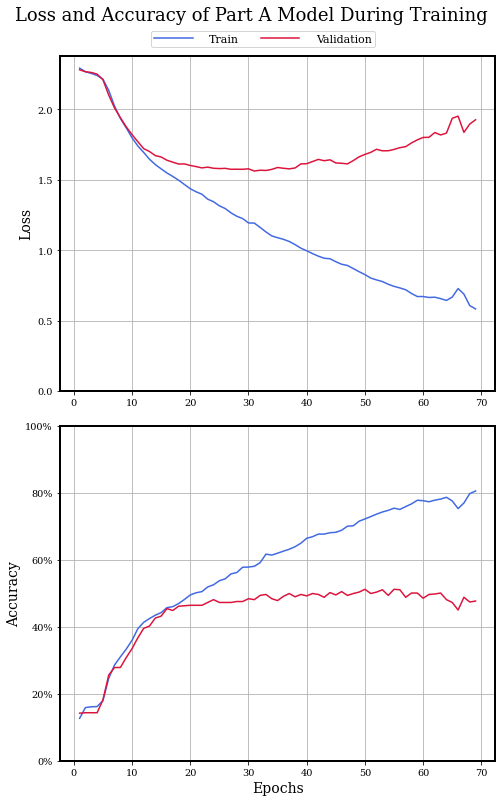

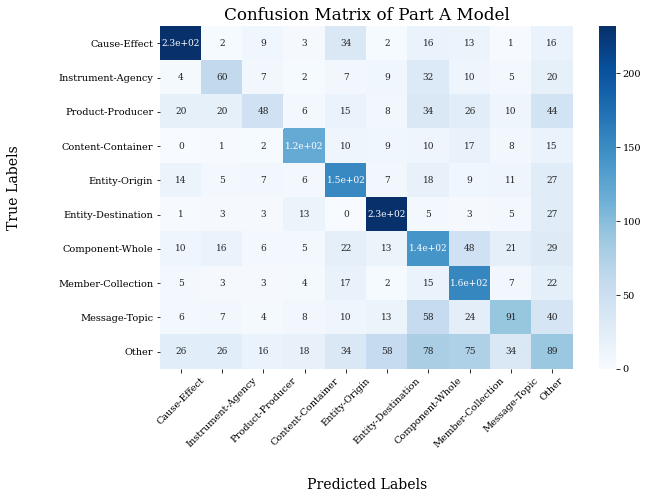

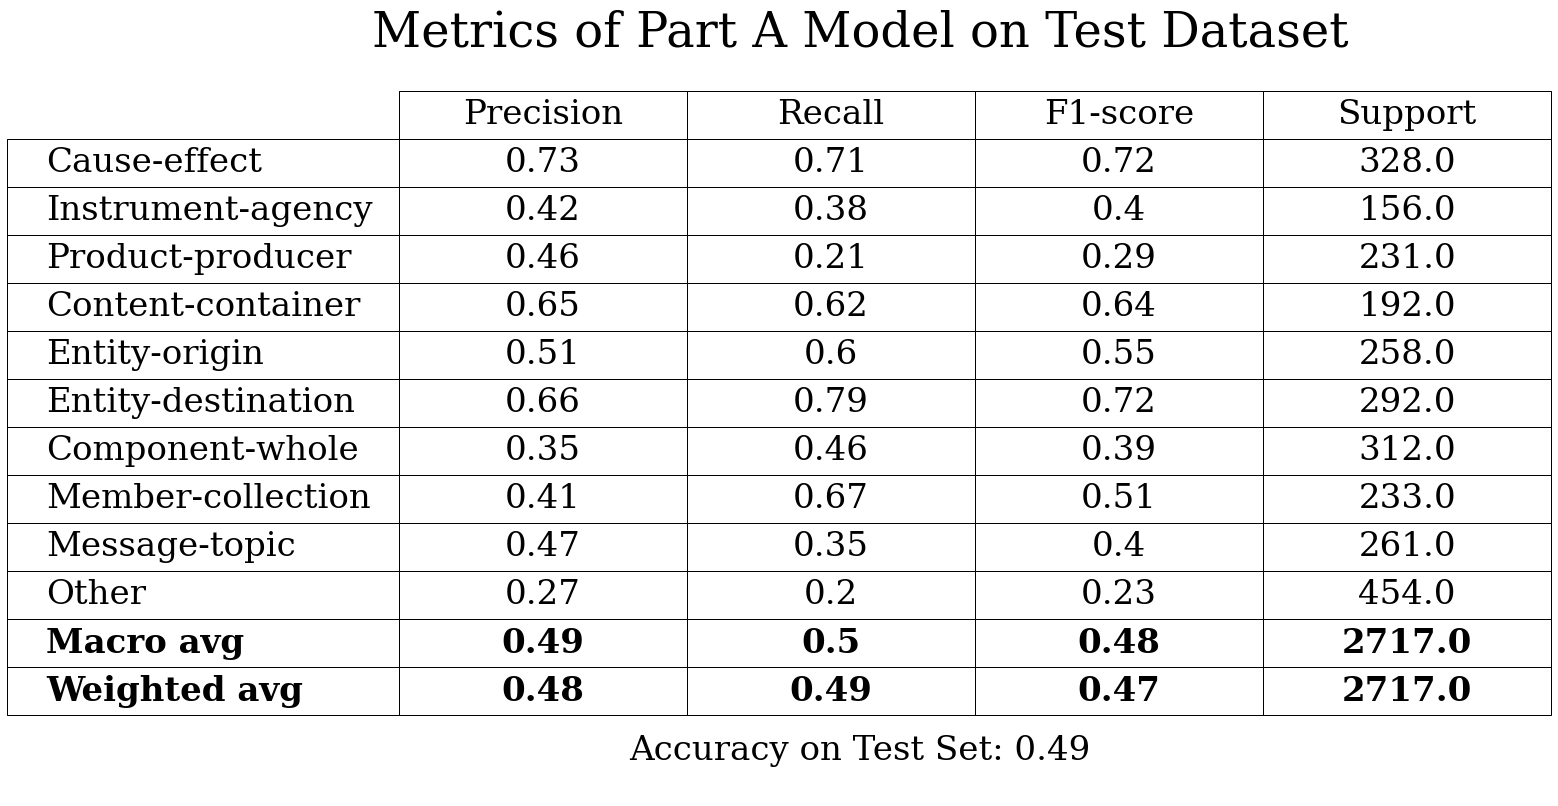

In [ ]:
label = "part_a"
visualize_info(label, train_info, test_info)

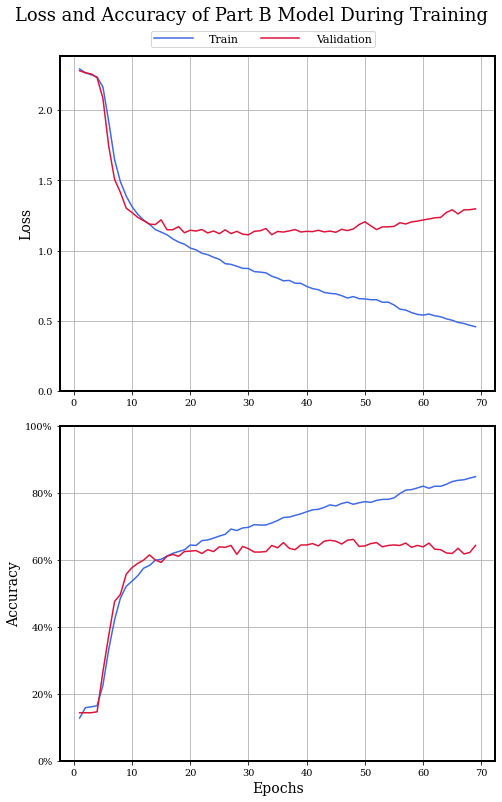

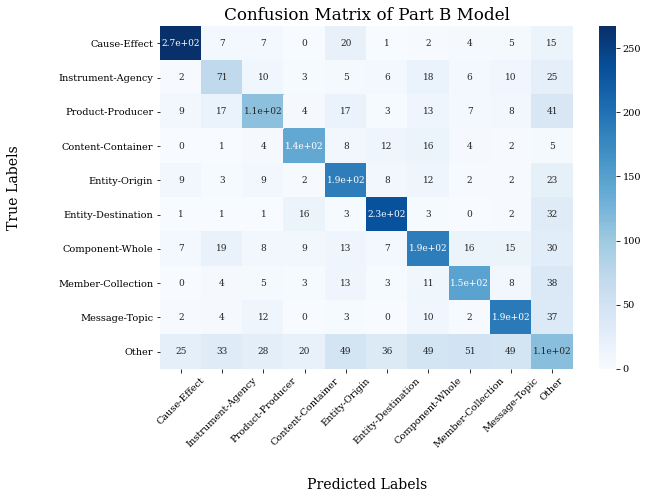

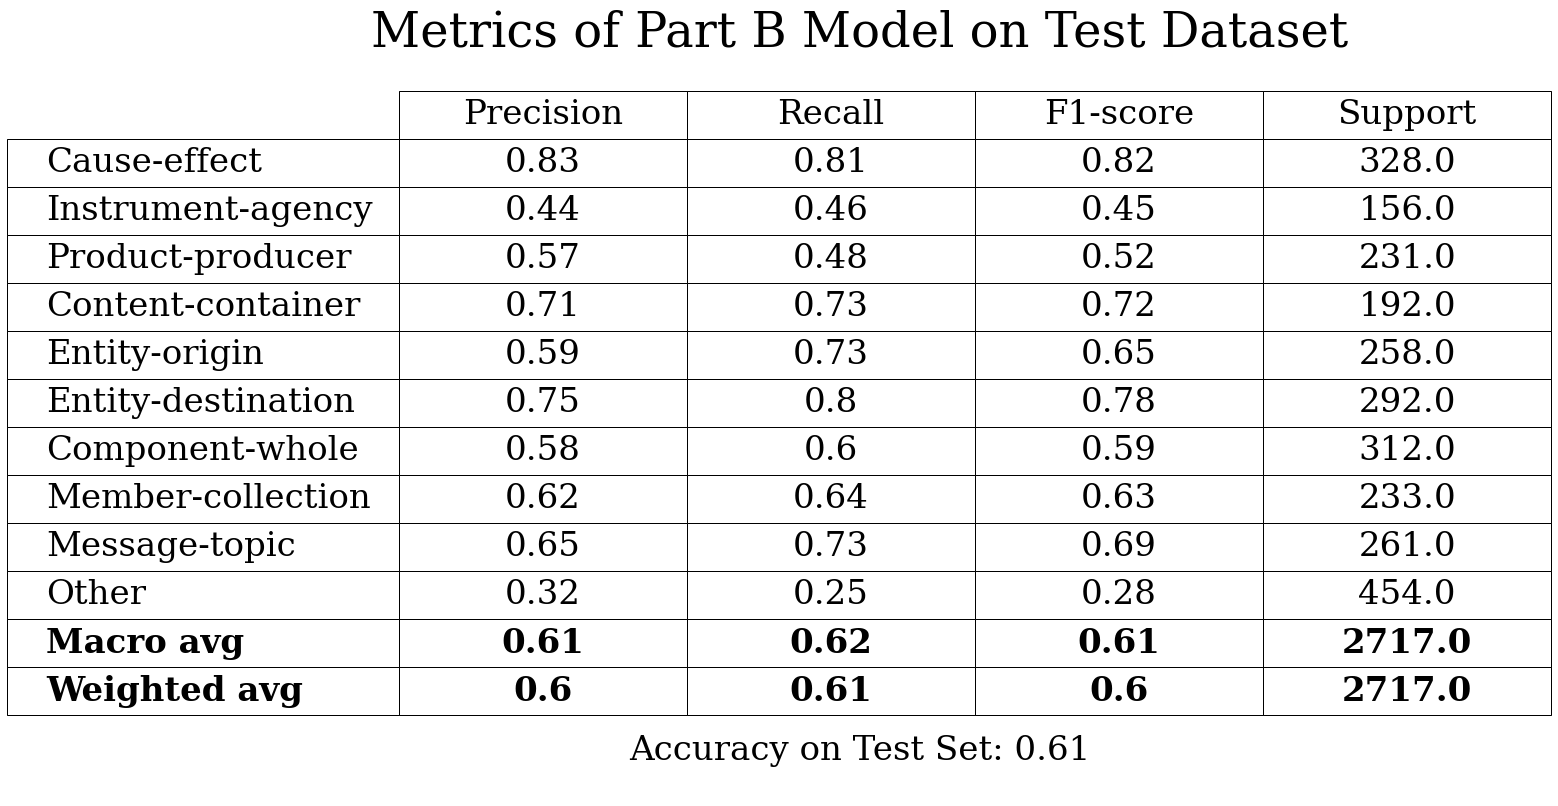

In [ ]:
label = "part_b"
visualize_info(label, train_info, test_info)

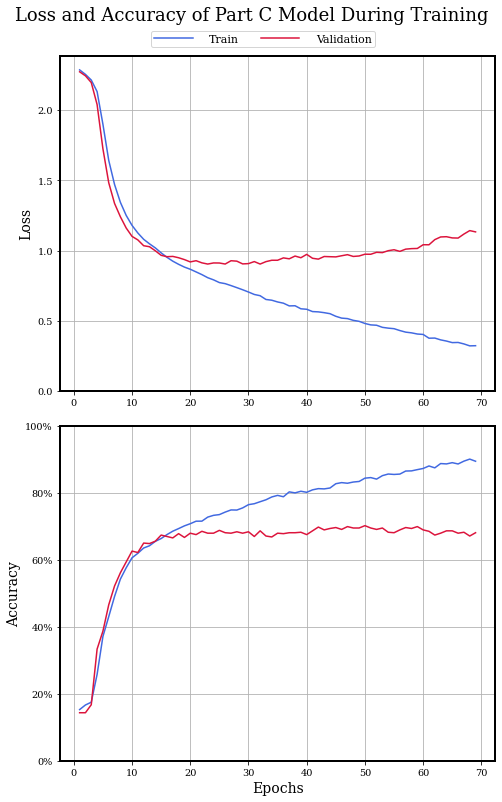

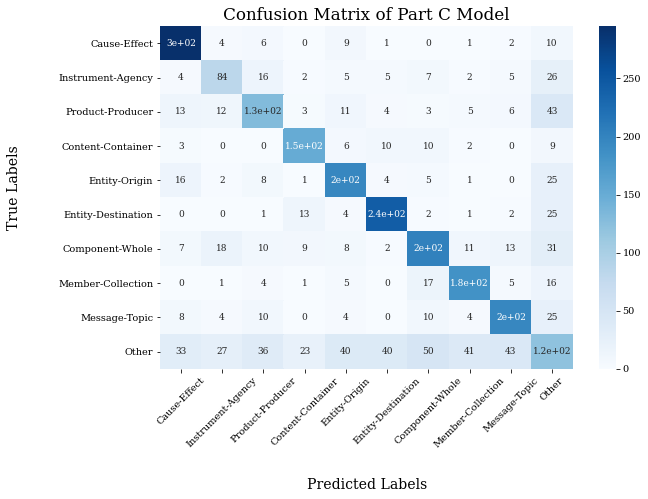

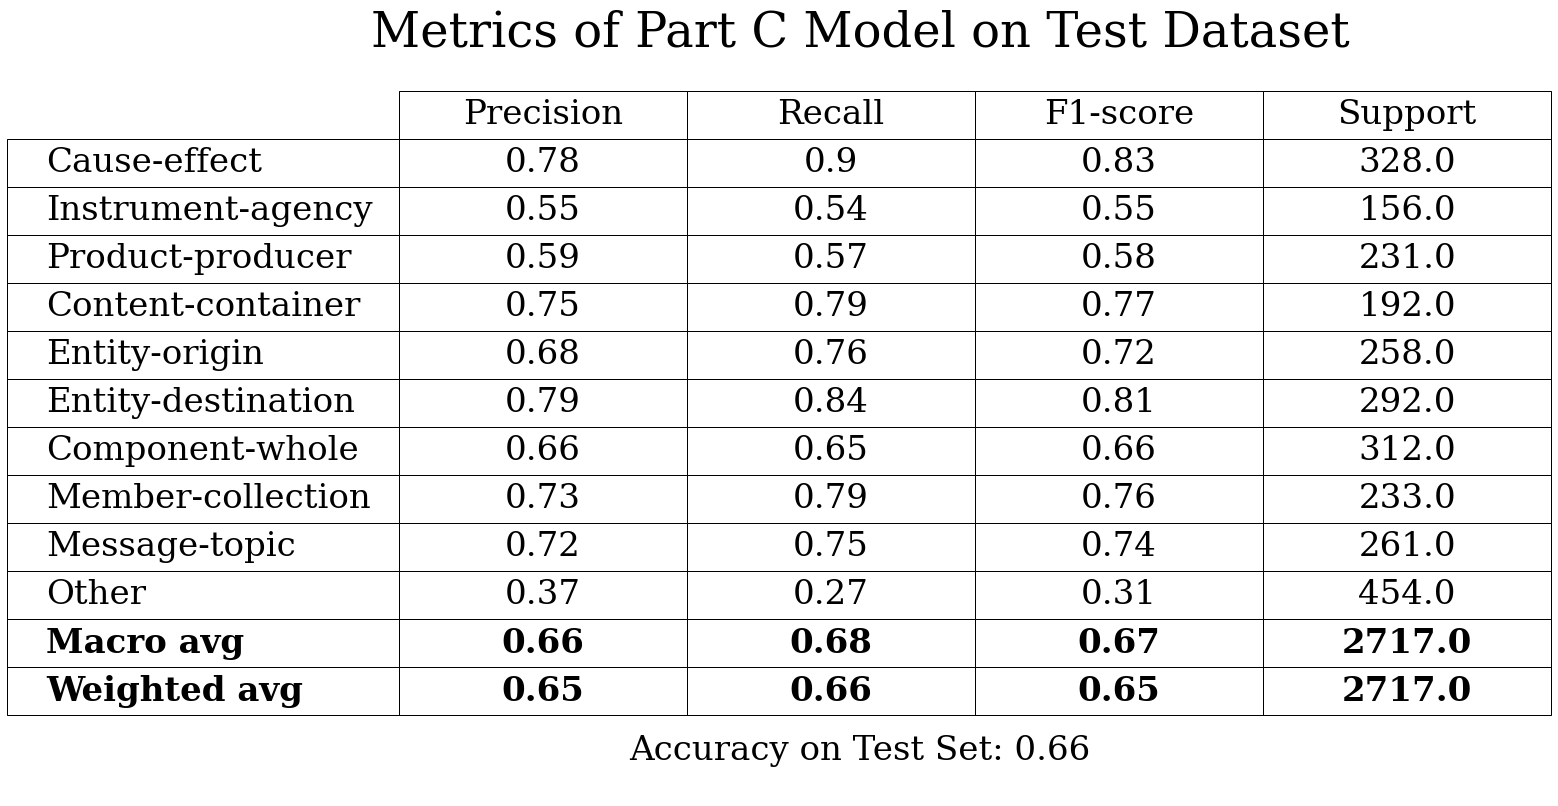

In [ ]:
label = "part_c"
visualize_info(label, train_info, test_info)